<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <b>AUC</b> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
            </li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    </li>
    <li>Along with plotting ROC curve, you need to print the <b>confusion matrix</b> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    </li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a>
    </li>
        </ul>
</ol>

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import math

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Loading previously cleaned preprocessed data (Only Considering Cleaned_Text & Score Variables) <a href="https://github.com/ParveshDhawan/Amazon_Review_Case_Study/blob/main/Amazon%20Fine%20Food%20Reviews%20Analysis_Word_Embedding_TSNE.ipynb"> LINK </a>


In [2]:
# Load Data 
conn = sqlite3.connect('../data/Preprocessed_Data.sqlite')
df = pd.read_sql_query("Select Cleaned_Text, Cleaned_Summary, Score from Reviews order by Time desc limit 100000;",conn)
# df = pd.read_sql_query("Select * from Reviews order by Time desc limit 100000;",conn)
df['Score'] = df.Score.apply(lambda x : 1 if x == 'positive' else -1)

#### Creating New Feature as : Cleaned_Text(Review Text) + Cleaned_Summary
df['Mix_Text'] = df[['Cleaned_Text','Cleaned_Summary']].apply(lambda x : ' '.join([x[0],x[1]]), axis=1)

df.head()

,Cleaned_Text,Cleaned_Summary,Score,Mix_Text
0,love faucet husband installed one old house cu...,love faucet,1,love faucet husband installed one old house cu...
1,gone treat dinner treat dogs work run chance l...,dogs love,1,gone treat dinner treat dogs work run chance l...
2,no instructions provided trap would not open t...,defective device,-1,no instructions provided trap would not open t...
3,well built mole trap works great set correctly...,great mole trap,1,well built mole trap works great set correctly...
4,got give goodie bag holidays couple extras cou...,perfect gift,1,got give goodie bag holidays couple extras cou...


### Splitting Data into Train, Validation & Test Set

In [3]:
# Splitting Data
X_train,X_test,Y_train,Y_test = train_test_split(df.Cleaned_Text.values, df.Score.values, test_size=0.2, random_state=143, shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=143, shuffle=False)
print(X_train.shape, X_val.shape, X_test.shape)

(64000,) (16000,) (20000,)


> - #### Helper Functions

In [4]:
def check_optimal_k(x_train,x_val,y_train, y_val, alpha_v):
    train_auc = []
    val_auc = []
    for k in tqdm(alpha_v):
        classifier = MultinomialNB(alpha = k).fit(x_train, y_train)
        Y_train_pred = classifier.predict_proba(x_train)[:,1]
        train_auc.append(roc_auc_score(y_train, Y_train_pred))
        
        Y_val_pred = classifier.predict_proba(x_val)[:,1]
        val_auc.append(roc_auc_score(y_val, Y_val_pred))
        # cross_val_score(neigh, X_val_bow, Y_val, cv=10, scoring='roc_auc').mean()

    optimal_alpha= alpha_v[val_auc.index(max(val_auc))]
    alpha_v=[math.log(x) for x in alpha_v]
    
    plt.figure(figsize=(12, 10))
    plt.plot(alpha_v, train_auc, label='Train AUC')
    plt.scatter(alpha_v, train_auc, label='train_alpha')
    plt.plot(alpha_v, val_auc, label='Val AUC')
    plt.scatter(alpha_v, val_auc, label='val_alpha')
    plt.legend()
    plt.xlabel("log(alpha)")
    plt.ylabel("AUC")
    plt.title(f"AUC vs Hyperparameters")
    plt.show()
    print('optimal alpha for which auc is maximum : ',optimal_alpha)
    return optimal_alpha
    
    
    
def optimal_value_model(optimal_alpha, x_train, y_train, x_test, y_test):
    optimal_model = MultinomialNB(alpha = optimal_alpha).fit(x_train, y_train)
    prediction = optimal_model.predict(x_test)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, optimal_model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, optimal_model.predict_proba(x_test)[:,1])
    Final_AUC_Score_train = auc(train_fpr, train_tpr)
    Final_AUC_Score_test = auc(test_fpr, test_tpr)
    
    plt.figure(figsize=(12, 10))
    plt.plot(train_fpr, train_tpr, label="train ROC, AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test ROC, AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC")
    plt.show()
    
    print(classification_report(y_test, prediction))
    
    return [Final_AUC_Score_train, Final_AUC_Score_test, optimal_alpha], optimal_model



def confusion_matrix_plot(optimal_model,x_train, y_train, x_test, y_test):
    conf_matrix_train = confusion_matrix(y_train,optimal_model.predict(x_train))
    conf_matrix_test = confusion_matrix(y_test,optimal_model.predict(x_test))
    class_label =[-1,1]

    df_conf_matrix_train = pd.DataFrame(conf_matrix_train, index=class_label, columns = class_label)
    df_conf_matrix_test = pd.DataFrame(conf_matrix_test, index = class_label, columns = class_label)

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    sns.heatmap(df_conf_matrix_train, annot=True, fmt='d', cmap="YlGnBu", ax=ax[1])
    ax[1].set_title("confusion_matrix for train")
    ax[1].set(xlabel='Predicted', ylabel='Actual')

    sns.heatmap(df_conf_matrix_test, annot=True, fmt='d', cmap="YlGnBu", ax=ax[0])
    ax[0].set_title("confusion_matrix for Test")
    ax[0].set(xlabel='Predicted', ylabel='Actual')
    plt.show()

### Apply Naive Bayes
>- ##### BOW (Bag of Words)

  9%|▉         | 1/11 [00:00<00:01,  7.70it/s]

(64000, 37532) (16000, 37532) (20000, 37532)


100%|██████████| 11/11 [00:01<00:00,  8.76it/s]


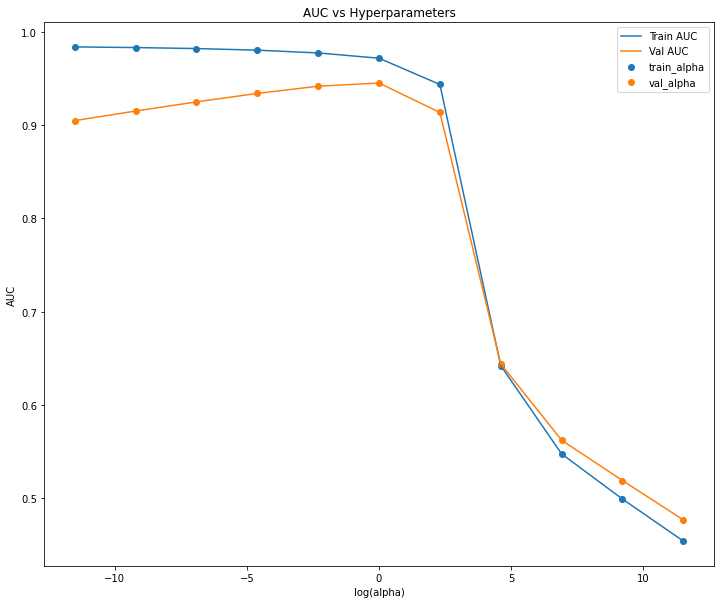

optimal alpha for which auc is maximum :  1


In [5]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2) ,min_df=10).fit(X_train)
X_train_bow = bow_vectorizer.transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)
alpha_v = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5

optimal_alpha = check_optimal_k(X_train_bow,X_val_bow,Y_train, Y_val, alpha_v)

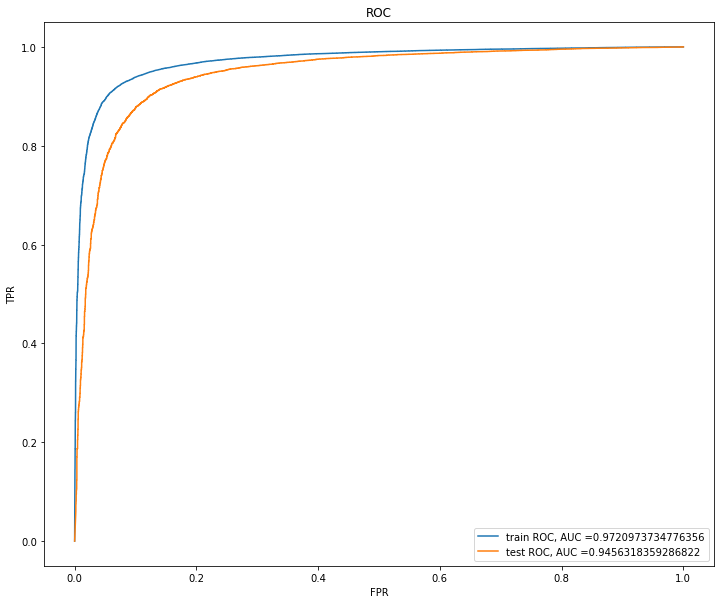

              precision    recall  f1-score   support

          -1       0.73      0.81      0.77      3556
           1       0.96      0.93      0.95     16444

    accuracy                           0.91     20000
   macro avg       0.84      0.87      0.86     20000
weighted avg       0.92      0.91      0.92     20000



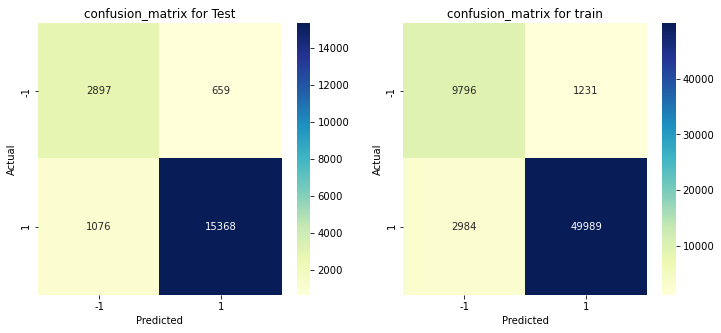

Positive features top 10 ---> ['not', 'like', 'good', 'great', 'one', 'product', 'taste', 'love', 'coffee', 'would']
Negative features top 10 ---> ['not', 'like', 'product', 'would', 'taste', 'one', 'no', 'good', 'coffee', 'flavor']


In [6]:
AUC_BOW,model = optimal_value_model(optimal_alpha, X_train_bow, Y_train, X_test_bow, Y_test)
confusion_matrix_plot(model,X_train_bow, Y_train, X_test_bow, Y_test)

features = model.feature_log_prob_ #log probability of features given a class
Negative_features = np.argsort(features[0])[::-1]#Returns the indices that would sort an array
Positive_features = np.argsort(features[1])[::-1]

feature_names = bow_vectorizer.get_feature_names()

print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Positive_features[:10])]}')
print(f'Negative features top 10 ---> {[feature_names[i] for i in list(Negative_features[:10])]}')

>- ##### TF-IDF 

  9%|▉         | 1/11 [00:00<00:01,  9.18it/s]

(64000, 37532) (16000, 37532) (20000, 37532)


100%|██████████| 11/11 [00:01<00:00,  9.44it/s]


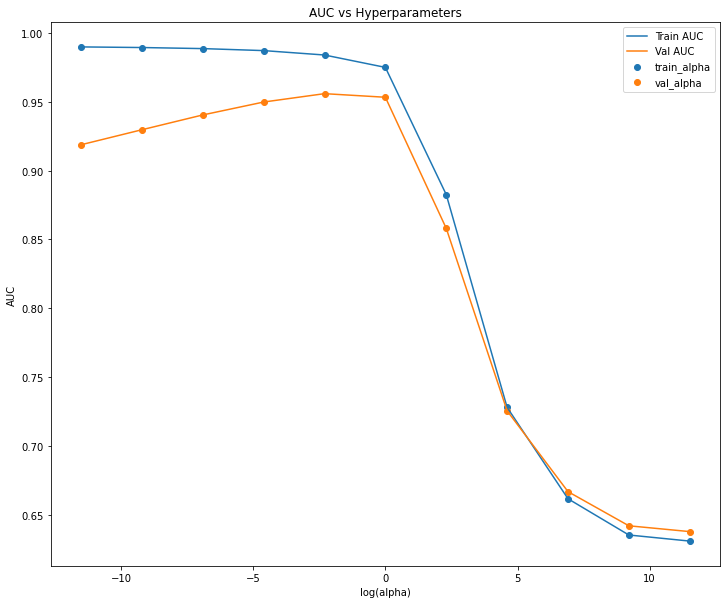

optimal alpha for which auc is maximum :  0.1


In [7]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2) ,min_df=10).fit(X_train)
Tfidf_train = Tfidf_vect.transform(X_train)
Tfidf_val = Tfidf_vect.transform(X_val)
Tfidf_test = Tfidf_vect.transform(X_test)
print(Tfidf_train.shape, Tfidf_val.shape, Tfidf_test.shape)

alpha_v = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5

optimal_alpha = check_optimal_k(Tfidf_train, Tfidf_val,Y_train, Y_val, alpha_v)

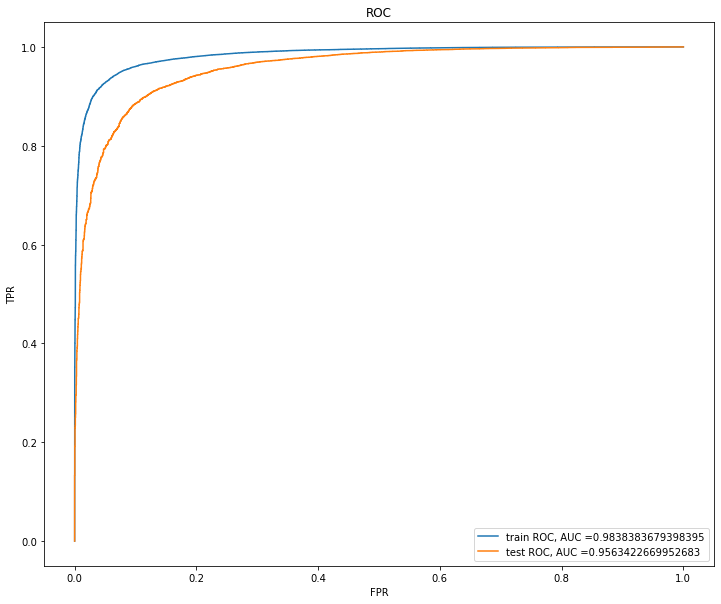

              precision    recall  f1-score   support

          -1       0.90      0.54      0.67      3556
           1       0.91      0.99      0.95     16444

    accuracy                           0.91     20000
   macro avg       0.90      0.76      0.81     20000
weighted avg       0.91      0.91      0.90     20000



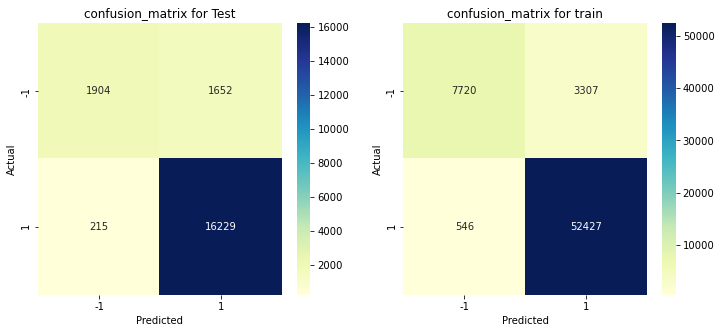

Positive features top 10 ---> ['not', 'great', 'good', 'like', 'coffee', 'love', 'product', 'tea', 'taste', 'one']
Positive features top 10 ---> ['not', 'product', 'like', 'would', 'taste', 'one', 'coffee', 'no', 'buy', 'flavor']


In [8]:
AUC_tfidf,model = optimal_value_model(optimal_alpha, Tfidf_train, Y_train, Tfidf_test, Y_test)
confusion_matrix_plot(model, Tfidf_train, Y_train, Tfidf_test, Y_test)

features = model.feature_log_prob_ #log probability of features given a class
Negative_features = np.argsort(features[0])[::-1]#Returns the indices that would sort an array
Positive_features = np.argsort(features[1])[::-1]

feature_names = Tfidf_vect.get_feature_names()

print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Positive_features[:10])]}')
print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Negative_features[:10])]}')

In [9]:
[feature_names[i] for i in list(Positive_features[:10])]

['not',
 'great',
 'good',
 'like',
 'coffee',
 'love',
 'product',
 'tea',
 'taste',
 'one']

### With New Feature Created as MIX

In [10]:
# Splitting Data
X_train,X_test,Y_train,Y_test = train_test_split(df.Mix_Text.values, df.Score.values, test_size=0.2, random_state=143, shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=143, shuffle=False)
print(X_train.shape, X_val.shape, X_test.shape)

(64000,) (16000,) (20000,)


> - ##### BOW (Mixed Feature)

  9%|▉         | 1/11 [00:00<00:01,  8.85it/s]

(64000, 39974) (16000, 39974) (20000, 39974)


100%|██████████| 11/11 [00:01<00:00,  8.62it/s]


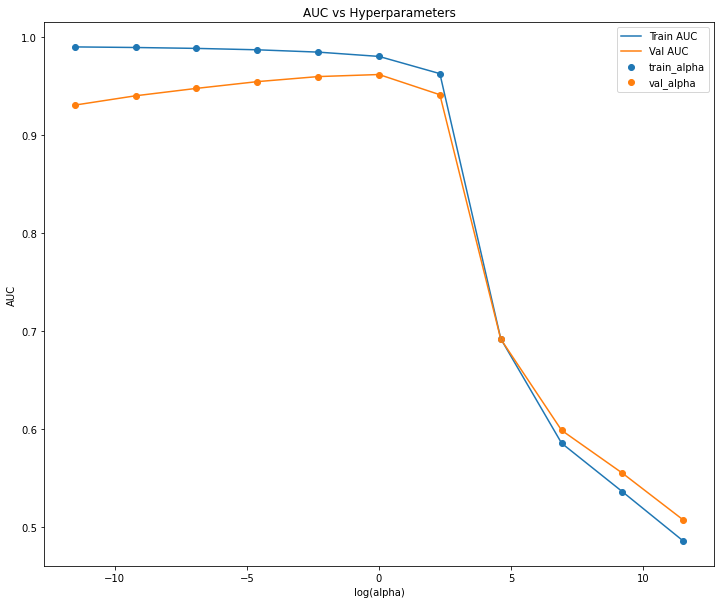

optimal alpha for which auc is maximum :  1


In [11]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2) ,min_df=10).fit(X_train)
X_train_bow = bow_vectorizer.transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)
alpha_v = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5

optimal_alpha = check_optimal_k(X_train_bow,X_val_bow,Y_train, Y_val, alpha_v)

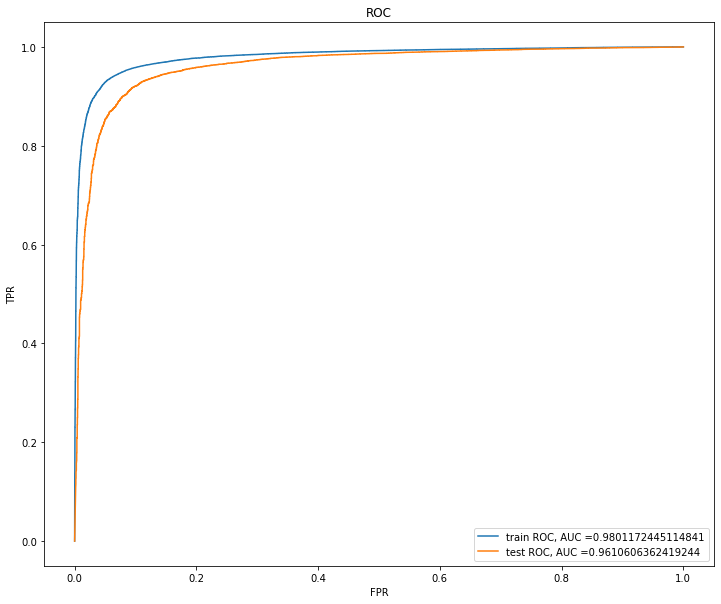

              precision    recall  f1-score   support

          -1       0.76      0.86      0.81      3556
           1       0.97      0.94      0.96     16444

    accuracy                           0.93     20000
   macro avg       0.87      0.90      0.88     20000
weighted avg       0.93      0.93      0.93     20000



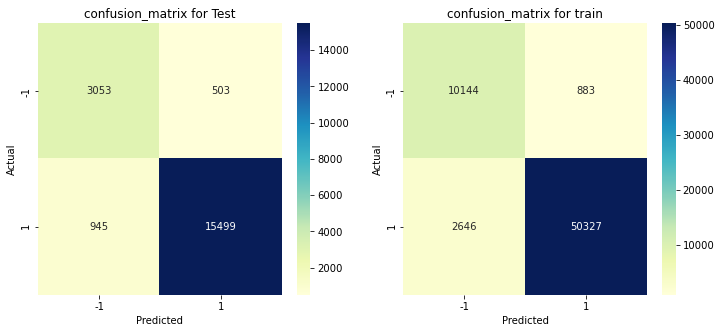

Positive features top 10 ---> ['not', 'great', 'good', 'like', 'love', 'product', 'coffee', 'one', 'taste', 'flavor']
Negative features top 10 ---> ['not', 'like', 'product', 'would', 'taste', 'one', 'good', 'no', 'coffee', 'flavor']


In [12]:
AUC_BOW_f,model = optimal_value_model(optimal_alpha, X_train_bow, Y_train, X_test_bow, Y_test)
confusion_matrix_plot(model,X_train_bow, Y_train, X_test_bow, Y_test)

features = model.feature_log_prob_ #log probability of features given a class
Negative_features = np.argsort(features[0])[::-1]#Returns the indices that would sort an array
Positive_features = np.argsort(features[1])[::-1]

feature_names = bow_vectorizer.get_feature_names()

print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Positive_features[:10])]}')
print(f'Negative features top 10 ---> {[feature_names[i] for i in list(Negative_features[:10])]}')

> - ##### Tf-Idf (Mixed Featured)

  9%|▉         | 1/11 [00:00<00:01,  8.55it/s]

(64000, 39974) (16000, 39974) (20000, 39974)


100%|██████████| 11/11 [00:01<00:00,  9.09it/s]


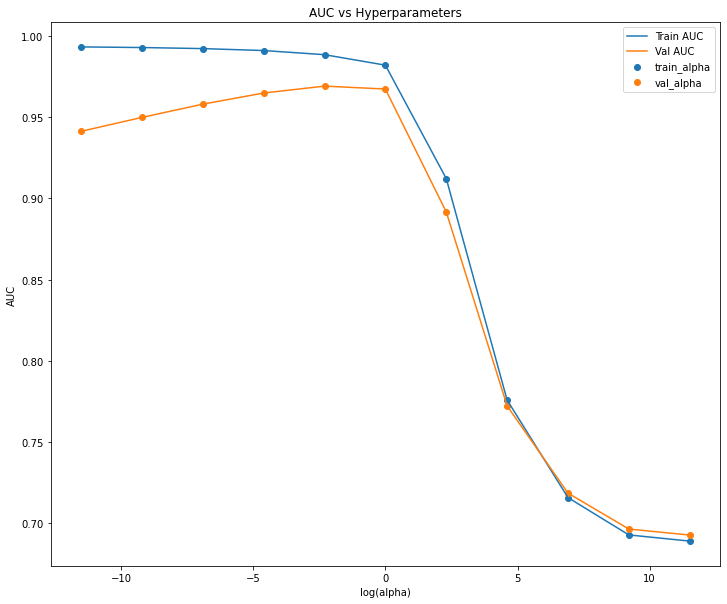

optimal alpha for which auc is maximum :  0.1


In [13]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2) ,min_df=10).fit(X_train)
Tfidf_train = Tfidf_vect.transform(X_train)
Tfidf_val = Tfidf_vect.transform(X_val)
Tfidf_test = Tfidf_vect.transform(X_test)
print(Tfidf_train.shape, Tfidf_val.shape, Tfidf_test.shape)

alpha_v = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5

optimal_alpha = check_optimal_k(Tfidf_train, Tfidf_val,Y_train, Y_val, alpha_v)

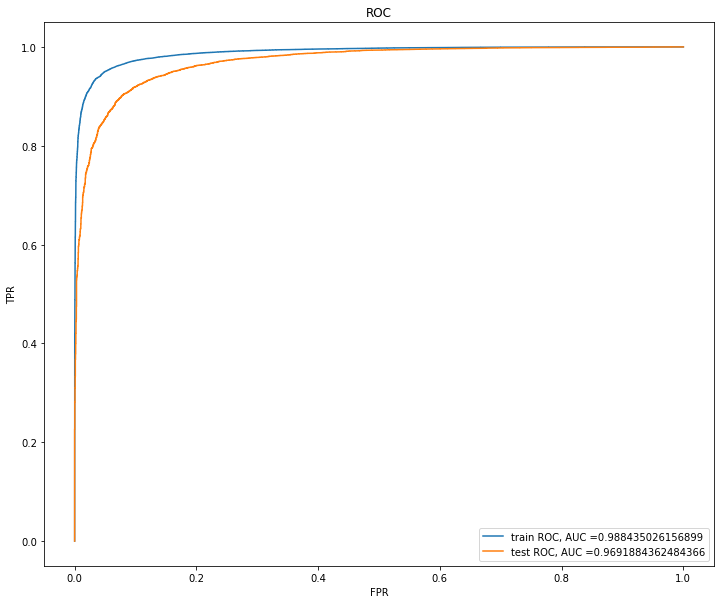

              precision    recall  f1-score   support

          -1       0.91      0.61      0.73      3556
           1       0.92      0.99      0.95     16444

    accuracy                           0.92     20000
   macro avg       0.92      0.80      0.84     20000
weighted avg       0.92      0.92      0.91     20000



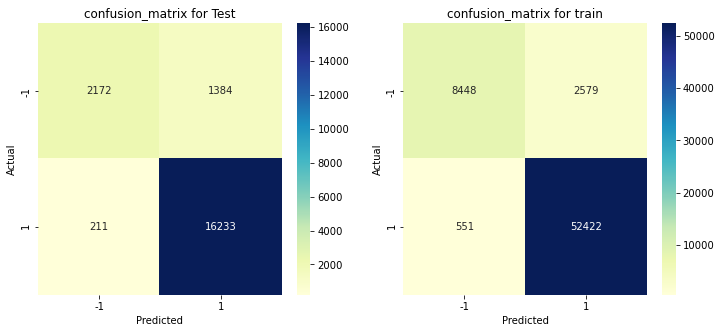

Positive features top 10 ---> ['not', 'great', 'good', 'coffee', 'love', 'like', 'product', 'tea', 'taste', 'flavor']
Positive features top 10 ---> ['not', 'product', 'like', 'taste', 'would', 'coffee', 'no', 'one', 'buy', 'flavor']


In [14]:
AUC_tfidf_f,model = optimal_value_model(optimal_alpha, Tfidf_train, Y_train, Tfidf_test, Y_test)
confusion_matrix_plot(model, Tfidf_train, Y_train, Tfidf_test, Y_test)

features = model.feature_log_prob_ #log probability of features given a class
Negative_features = np.argsort(features[0])[::-1]#Returns the indices that would sort an array
Positive_features = np.argsort(features[1])[::-1]

feature_names = Tfidf_vect.get_feature_names()

print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Positive_features[:10])]}')
print(f'Positive features top 10 ---> {[feature_names[i] for i in list(Negative_features[:10])]}')

In [17]:
from prettytable import PrettyTable
comparison = PrettyTable()

comparison.field_names = ["Vectorizer", "Features Used","Hyperparameter", "Train-AUC", "Test-AUC"]

comparison.add_row(["BOW",   "Review Feature",     AUC_BOW[2], np.round(float(AUC_BOW[0]),3), np.round(float(AUC_BOW[1]),3)])
comparison.add_row(["BOW",   "Review + Summary",   AUC_BOW_f[2], np.round(float(AUC_BOW_f[0]),3), np.round(float(AUC_BOW_f[1]),3)])
comparison.add_row(['--','--','--','--','--'])
comparison.add_row(["TFIDF", "Review Feature",     AUC_tfidf[2], np.round(float(AUC_tfidf[0]),3), np.round(float(AUC_tfidf[1]),3)])
comparison.add_row(["TFIDF", "Review + Summary",   AUC_tfidf_f[2], np.round(float(AUC_tfidf_f[0]),3), np.round(float(AUC_tfidf_f[1]),3)])
print(comparison)

+------------+------------------+----------------+-----------+----------+
| Vectorizer |  Features Used   | Hyperparameter | Train-AUC | Test-AUC |
+------------+------------------+----------------+-----------+----------+
|    BOW     |  Review Feature  |       1        |   0.972   |  0.946   |
|    BOW     | Review + Summary |       1        |    0.98   |  0.961   |
|     --     |        --        |       --       |     --    |    --    |
|   TFIDF    |  Review Feature  |      0.1       |   0.984   |  0.956   |
|   TFIDF    | Review + Summary |      0.1       |   0.988   |  0.969   |
+------------+------------------+----------------+-----------+----------+
